In [49]:
# Аналіз A/B-тесту — Експеримент з ціноутворенням

# Мета
# Оцінити вплив зміни цін на показники конверсії передплати та доходу.

# Бізнес-контекст
# Експеримент перевіряє, чи покращує нове ціноутворення конверсію, не знижуючи ARPU.



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# завантажуємо файл (при завантажені були проблеми через ";")
df = pd.read_csv("data/ab_test_data.csv", sep=";")


# Переглядаємо наш дата сет
df.head(20)



,user_id,install_date,country,test_group,trial,paid,subscription_name,revenue_1m
0,0000dd3fa4702a63d1b76aaffe1ab39b,05.06.2023,US,treatment,0,0,NaN,0
1,0001f27ab7e22228e54c8b2028b43f24,07.06.2023,AU,treatment,0,0,NaN,0
2,0006c5c547801308b36ea3cf669856ae,07.06.2023,AU,treatment,0,0,NaN,0
3,000d1a300263c5db91cbefa3852898a7,07.06.2023,AU,control,0,0,NaN,0
4,000e5e62e8746e467ed9f49ac5de3208,06.06.2023,US,treatment,0,0,NaN,0
5,000e65027879059fe2a814be4ff21316,04.06.2023,CA,treatment,0,0,NaN,0
6,000eb23cf1caf152d9b8d4ec2441e085,02.06.2023,AU,control,0,0,NaN,0
7,0013a6c091188301710271b8195a999a,03.06.2023,GB,treatment,0,0,NaN,0
8,001f99c190cb677eadbbe144a5c7eb02,01.06.2023,CA,treatment,0,0,NaN,0
9,002066ee39aacf3dbe4294be1a08bd77,06.06.2023,GB,control,0,0,NaN,0


In [50]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 15285 entries, 0 to 15284
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   user_id            15285 non-null  str  
 1   install_date       15285 non-null  str  
 2   country            15285 non-null  str  
 3   test_group         15285 non-null  str  
 4   trial              15285 non-null  int64
 5   paid               15285 non-null  int64
 6   subscription_name  1723 non-null   str  
 7   revenue_1m         15285 non-null  str  
dtypes: int64(2), str(6)
memory usage: 955.4 KB


In [51]:
df.describe()

,trial,paid
count,15285.000000,15285.000000
mean,0.112725,0.017337
std,0.316267,0.130529
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [52]:
# Оскільки формат дати str міняєм його на datetime також формат revenue_1m міняємо на float
df['install_date'] = pd.to_datetime(df['install_date'], dayfirst=True)

df["revenue_1m"] = (
    df["revenue_1m"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .astype(float)
)

df.isna().sum()


user_id                  0
install_date             0
country                  0
test_group               0
trial                    0
paid                     0
subscription_name    13562
revenue_1m               0
dtype: int64

In [53]:
# Порівнюємо тестові групи Очікуємо ±50/50 (допустимо 45–55%)
df['test_group'].value_counts()


test_group
treatment    7658
control      7627
Name: count, dtype: int64

In [54]:
# Дивимось чи немає перекосу у регіонах
pd.crosstab(df['country'], df['test_group'], normalize='index')


test_group,control,treatment
country,,
AU,0.512357,0.487643
CA,0.497047,0.502953
GB,0.481105,0.518895
US,0.505805,0.494195


In [55]:
# Перевірка валідності експерименту
# Ми перевірили, що користувачі були розподілені порівну між контрольною та експериментальною групами,
# а також що розподіл за країнами був збалансованим.

# Дивимось тривалість тесту має бути 1 тиждень
df['install_date'].min(), df['install_date'].max()


(Timestamp('2023-06-01 00:00:00'), Timestamp('2023-06-07 00:00:00'))

In [56]:
## Обмеження
#- Коротка тривалість тестування (7 днів)
#- Дохід вимірюється лише за перший місяць
#- Аналіз відтоку клієнтів поки що відсутній

# Розділяємо на групи
control = df[df['test_group'] == 'control']
treatment = df[df['test_group'] == 'treatment']


In [57]:
# Розраховуємо конверсії Trial
trial_control_rate = control['trial'].mean()
trial_treatment_rate = treatment['trial'].mean()

trial_control_rate, trial_treatment_rate


(np.float64(0.12127966435033434), np.float64(0.10420475319926874))

In [58]:
# Розраховуємо конверсії Paid
paid_control_rate = control['paid'].mean()
paid_treatment_rate = treatment['paid'].mean()

paid_control_rate, paid_treatment_rate


(np.float64(0.015209125475285171), np.float64(0.019456777226429876))

In [59]:
# Статистичний тест
from statsmodels.stats.proportion import proportions_ztest


In [60]:
# Z-test для Trial

trial_successes = np.array([
    control['trial'].sum(),
    treatment['trial'].sum()
])

trial_samples = np.array([
    len(control),
    len(treatment)
])

z_stat_trial, p_value_trial = proportions_ztest(
    count=trial_successes,
    nobs=trial_samples,
    alternative='two-sided'
)

z_stat_trial, p_value_trial


(np.float64(3.3374995783424692), np.float64(0.0008453585013877691))

In [61]:
# Z-test для Paid

paid_successes = np.array([
    control['paid'].sum(),
    treatment['paid'].sum()
])

paid_samples = np.array([
    len(control),
    len(treatment)
])

z_stat_paid, p_value_paid = proportions_ztest(
    count=paid_successes,
    nobs=paid_samples,
    alternative='two-sided'
)

z_stat_paid, p_value_paid


(np.float64(-2.011677116982162), np.float64(0.04425398431753958))

In [62]:
# Рахуємо базові метрики по групах

summary = (
    df
    .groupby("test_group")
    .agg(
        installs=("user_id", "count"),
        trials=("trial", "sum"),
        paid_users=("paid", "sum"),
        revenue=("revenue_1m", "sum")
    )
)

summary["trial_cr"] = summary["trials"] / summary["installs"]
summary["paid_cr"] = summary["paid_users"] / summary["installs"]
summary["rpi"] = summary["revenue"] / summary["installs"]

summary


,installs,trials,paid_users,revenue,trial_cr,paid_cr,rpi
test_group,,,,,,,
control,7627,925,116,694.84,0.121280,0.015209,0.091103
treatment,7658,798,149,792.35,0.104205,0.019457,0.103467


In [63]:
# Revenue Uplift (ключовий розрахунок)

rpi_control = summary.loc["control", "rpi"]
rpi_treatment = summary.loc["treatment", "rpi"]

uplift_abs = rpi_treatment - rpi_control
uplift_pct = uplift_abs / rpi_control

uplift_abs, uplift_pct


(np.float64(0.012364301056476137), np.float64(0.13571832962659533))

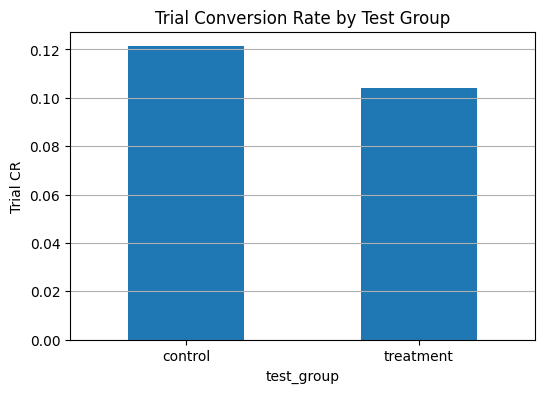

In [64]:

trial_rates = summary["trial_cr"]

plt.figure(figsize=(6,4))
trial_rates.plot(kind="bar")
plt.title("Trial Conversion Rate by Test Group")
plt.ylabel("Trial CR")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.savefig("trial_cr.png", dpi=200)
plt.show()


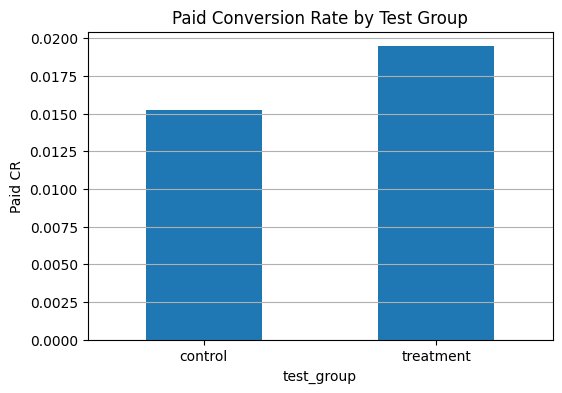

In [65]:
paid_rates = summary["paid_cr"]

plt.figure(figsize=(6,4))
paid_rates.plot(kind="bar")
plt.title("Paid Conversion Rate by Test Group")
plt.ylabel("Paid CR")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.savefig("paid_cr.png", dpi=200)
plt.show()


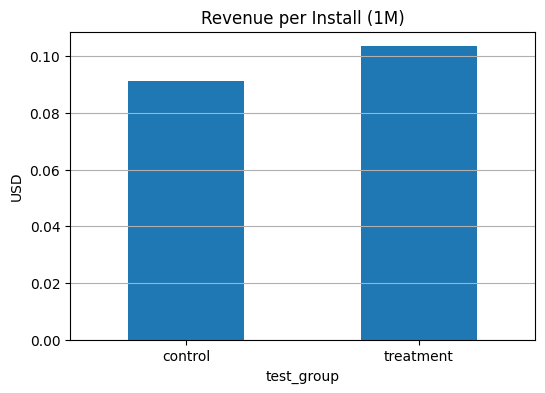

In [66]:
rpi = summary["rpi"]

plt.figure(figsize=(6,4))
rpi.plot(kind="bar")
plt.title("Revenue per Install (1M)")
plt.ylabel("USD")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.savefig("rpi.png", dpi=200)
plt.show()


In [67]:
# Базова агрегація по країнах
country_summary = (
    df
    .groupby(["country", "test_group"])
    .agg(
        installs=("user_id", "count"),
        trials=("trial", "sum"),
        paid=("paid", "sum"),
        revenue=("revenue_1m", "sum")
    )
    .reset_index()
)

country_summary["trial_cr"] = country_summary["trials"] / country_summary["installs"]
country_summary["paid_cr"] = country_summary["paid"] / country_summary["installs"]
country_summary["rpi"] = country_summary["revenue"] / country_summary["installs"]

country_summary


,country,test_group,installs,trials,paid,revenue,trial_cr,paid_cr,rpi
0,AU,control,1928,228,30,179.70,0.118257,0.015560,0.093205
1,AU,treatment,1835,191,39,209.30,0.104087,0.021253,0.114060
2,CA,control,1936,219,18,107.82,0.113120,0.009298,0.055692
3,CA,treatment,1959,208,37,185.38,0.106177,0.018887,0.094630
4,GB,control,1846,270,35,209.65,0.146262,0.018960,0.113570
5,GB,treatment,1991,209,41,221.26,0.104972,0.020593,0.111130
6,US,control,1917,208,33,197.67,0.108503,0.017214,0.103114
7,US,treatment,1873,190,32,176.41,0.101442,0.017085,0.094186


In [68]:
# Порівняння control vs treatment по країнах

pivot = country_summary.pivot(
    index="country",
    columns="test_group",
    values=["trial_cr", "paid_cr", "rpi"]
)

pivot["trial_uplift_%"] = (
    (pivot["trial_cr"]["treatment"] / pivot["trial_cr"]["control"] - 1) * 100
)

pivot["paid_uplift_%"] = (
    (pivot["paid_cr"]["treatment"] / pivot["paid_cr"]["control"] - 1) * 100
)

pivot["rpi_uplift_%"] = (
    (pivot["rpi"]["treatment"] / pivot["rpi"]["control"] - 1) * 100
)

pivot.round(2)


trial_cr           paid_cr               rpi            \
test_group  control treatment control treatment control treatment   
country                                                             
AU             0.12      0.10    0.02      0.02    0.09      0.11   
CA             0.11      0.11    0.01      0.02    0.06      0.09   
GB             0.15      0.10    0.02      0.02    0.11      0.11   
US             0.11      0.10    0.02      0.02    0.10      0.09   

           trial_uplift_% paid_uplift_% rpi_uplift_%  
test_group                                            
country                                               
AU                 -11.98         36.59        22.37  
CA                  -6.14        103.14        69.92  
GB                 -28.23          8.61        -2.15  
US                  -6.51         -0.75        -8.66

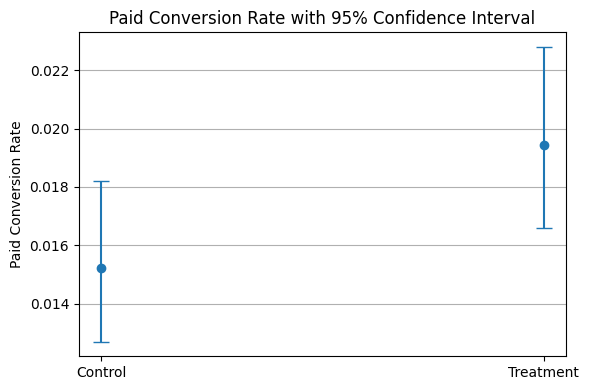

In [69]:
# Paid Conversion Rate + Confidence Interval (Control vs Treatment)

from statsmodels.stats.proportion import proportion_confint

# Дані
groups = ["Control", "Treatment"]

paid_rates = [
    control["paid"].mean(),
    treatment["paid"].mean()
]

# Confidence intervals
ci_control = proportion_confint(
    count=control["paid"].sum(),
    nobs=len(control),
    method="wilson"
)

ci_treatment = proportion_confint(
    count=treatment["paid"].sum(),
    nobs=len(treatment),
    method="wilson"
)

ci_lower = [
    paid_rates[0] - ci_control[0],
    paid_rates[1] - ci_treatment[0]
]

ci_upper = [
    ci_control[1] - paid_rates[0],
    ci_treatment[1] - paid_rates[1]
]

# Графік
plt.figure(figsize=(6,4))

plt.errorbar(
    groups,
    paid_rates,
    yerr=[ci_lower, ci_upper],
    fmt='o',
    capsize=6
)

plt.title("Paid Conversion Rate with 95% Confidence Interval")
plt.ylabel("Paid Conversion Rate")
plt.grid(axis="y")

plt.tight_layout()
plt.savefig("paid_ci.png", dpi=200)
plt.show()


In [ ]:
# Paid Conversion Rate + Confidence Interval (Control vs Treatment)

def bootstrap_uplift(df, n=5000):
    uplifts = []

    for _ in range(n):
        c = df[df.test_group == "control"].sample(frac=1, replace=True)
        t = df[df.test_group == "treatment"].sample(frac=1, replace=True)

        cr_c = c["paid"].mean()
        cr_t = t["paid"].mean()

        uplift = (cr_t / cr_c - 1) * 100
        uplifts.append(uplift)

    return np.array(uplifts)

uplifts = bootstrap_uplift(df)

# CI
ci_low, ci_median, ci_high = np.percentile(uplifts, [2.5, 50, 97.5])

# Графік
plt.figure(figsize=(7,4))

plt.hist(uplifts, bins=40)
plt.axvline(ci_low, linestyle="--", label=f"2.5%: {ci_low:.2f}%")
plt.axvline(ci_median, linestyle="-", label=f"Median: {ci_median:.2f}%")
plt.axvline(ci_high, linestyle="--", label=f"97.5%: {ci_high:.2f}%")

plt.title("Bootstrap Distribution of Paid CR Uplift")
plt.xlabel("Uplift (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis="y")

plt.tight_layout()
plt.savefig("paid_bootstrap.png", dpi=200)
plt.show()
